<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Judy/European_Call_jax2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   5808      0 --:--:-- --:--:-- --:--:--  5830
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 58.9 MB 32 kB/s 
     |████████████████████████████████| 1.0 MB 46.6 MB/s 
+ set +ex
Installation succeeded!


In [6]:
nstock = 3

In [2]:
################################# TEST ########################################
%%writefile cupy_dataset.py
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key, jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps,))
    dt = jnp.array(T[0]/numsteps)
    def time_step(t, val):
        dx =  drift * dt * val[t-1,:] + val[t-1,:] * jnp.sqrt(dt) * noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] + dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)


class NumbaOptionDataSet(object):
    
    def __init__(self, max_len=10, number_path = 1000, batch=2, seed=15, stocks=3):  # 3 stocks
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 365
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros(self.N_BATCH, dtype=cupy.float32)
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 6), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          key = random.PRNGKey(self.seed)
          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200)
          # cov=np.random.random((3,3))
          # cov=np.matmul(cov,cov.T)
          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))
          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r # To match BS, use drift = r
          T = jnp.array([self.T] * self.N_STOCKS)
          K = np.random.random(1) * 200

          fast_simple = jax.jit(Brownian_motion, static_argnums=2)
          fast_simple(key, initial_stocks, self.N_STEPS, drift, cov, T)

          numsamples = self.N_PATHS # num of paths
          keys = jax.random.split(key, numsamples)

          batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
          out = batch_simple(keys, initial_stocks, self.N_STEPS, drift, cov, T)

          European_Call_price = np.mean(np.maximum((np.mean(out[:,self.N_STEPS,:], axis=1)) - K, 0) * jnp.exp(-r[0] * T[0]))  #Call Price 計算???
          Y[op] = European_Call_price

          paras = (T, jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


ds = NumbaOptionDataSet(3, number_path = 100000, batch = 2, seed = 15, stocks=3)
#for i in ds:
    #print(i)

Writing cupy_dataset.py


In [3]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np


class Net(nn.Module):

    def __init__(self, hidden=1024, nstock=3):
        super(Net, self).__init__()
        self.nstock = nstock
        self.fc1 = nn.Linear(6 * self.nstock, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 1)
        self.register_buffer('norm',
                             torch.tensor([1, 150.0, 150.0, 0.4, 0.2, 0.2] * self.nstock)) # don't use numpy here - will give error later

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

Writing model.py


In [4]:
!pip install pytorch-ignite

     |████████████████████████████████| 232 kB 9.1 MB/s 


In [7]:
from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import NumbaOptionDataSet
timer = Timer(average=True)
model = Net(nstock = nstock).cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
# dataset = NumbaOptionDataSet(max_len = 10000, number_path = 1024, batch = 4800)
# dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = 3)
dataset = NumbaOptionDataSet(max_len = 100, number_path = 1024, batch = 32, stocks = nstock)


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    y_pred = model(x)
    loss = loss_fn(y_pred[:,0], y)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

loss 1202.71826171875 average time 0.44653754145000735 iter num 20
loss 1422.6795654296875 average time 0.22521192297500647 iter num 40
loss 327.9949951171875 average time 0.15145691261667574 iter num 60
loss 419.88641357421875 average time 0.11453426677500715 iter num 80
loss 383.86419677734375 average time 0.09240506698000558 iter num 100
loss 52.153648376464844 average time 0.06024596674999714 iter num 20
loss 7.4520368576049805 average time 0.03204111472500273 iter num 40
loss 6.675805568695068 average time 0.02264010463333553 iter num 60
loss 9.651689529418945 average time 0.017943451875002125 iter num 80
loss 1.9475466012954712 average time 0.015121505460003277 iter num 100
loss 2.359099864959717 average time 0.06048458819999496 iter num 20
loss 0.8865962028503418 average time 0.03215154807500653 iter num 40
loss 0.8972901105880737 average time 0.022698630750007474 iter num 60
loss 1.9532878398895264 average time 0.018017550987508457 iter num 80
loss 0.8149861693382263 average ti

ERROR:ignite.engine.engine.Engine:Engine run is terminating due to exception: 


KeyboardInterrupt: ignored

In [10]:
#### Using gradient, Change only 1 S0 at a time
%matplotlib inline
from torch.autograd import grad
import pylab
import numpy as np
def compute_delta(S, ith):
    inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))]).cuda()
    inputs.requires_grad = True
    x = model(inputs.float())
    #x = model(inputs)
    x.backward()
    first_order_gradient = inputs.grad
    return first_order_gradient[0][2]

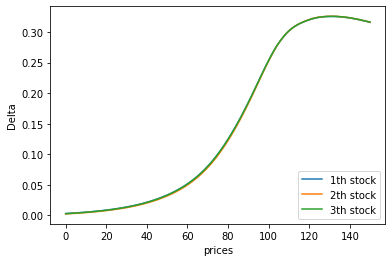

In [11]:
for i in range(1, nstock+1):
  prices = np.arange(0, 150, 0.1)
  deltas = []
  for p in prices:
      deltas.append(compute_delta(p, i).item())
  fig = pylab.plot(prices, deltas, label = f'{i}th stock')
  pylab.legend(loc = 'lower right')
  pylab.xlabel('prices')
  pylab.ylabel('Delta')
  fig

In [13]:
from jax import grad
def jax_delta(input):
  inputs = torch.tensor([[1, 110.0, 110.0, 0.35, 0.1, 0.05]*(ith-1)\
                           + [1, 110.0, S, 0.35, 0.1, 0.05]\
                           + ([1, 110.0, 110.0, 0.35, 0.1, 0.05]*(nstock-ith))])